**Init**

In [1]:
!pip install seqeval
!pip install transformers
!pip install --upgrade keras
!pip install --upgrade tensorflow

     |████████████████████████████████| 51kB 5.1MB/s 
  Created wheel for seqeval: filename=seqeval-1.2.2-cp37-none-any.whl size=16184 sha256=1d827f1df2d5e3220a00c467dc6f2fe1fa778ec870930ce47351ff3c76f96707
  Stored in directory: /root/.cache/pip/wheels/52/df/1b/45d75646c37428f7e626214704a0e35bd3cfc32eda37e59e5f
Successfully built seqeval
     |████████████████████████████████| 2.5MB 8.6MB/s 
     |████████████████████████████████| 3.3MB 37.5MB/s 
     |████████████████████████████████| 901kB 54.3MB/s 
Requirement already up-to-date: keras in /usr/local/lib/python3.7/dist-packages (2.4.3)
Requirement already up-to-date: tensorflow in /usr/local/lib/python3.7/dist-packages (2.5.0)


In [1]:
# Adapted from https://github.com/huggingface/transformers/tree/master/examples/token-classification

import logging
import os
import sys
import pandas as pd 
import torch
from dataclasses import dataclass, field
from typing import Dict, List, Optional, Tuple
import math

import numpy as np
from seqeval.metrics import f1_score, precision_score, recall_score, accuracy_score
from torch import nn

from transformers import (
    AutoConfig,
    AutoModelForTokenClassification,
    AutoTokenizer,
    EvalPrediction,
    Trainer,
    TrainingArguments
)

logger = logging.getLogger(__name__)

**What is a Data Class?**

This function is a decorator that is used to add generated special methods to classes, as described below.

The `dataclass()` decorator examines the class to find fields. A field is defined as class variable that has a type annotation. With two exceptions described below, nothing in `dataclass()` examines the type specified in the variable annotation.

The parameters to `dataclass()` are:

- `init`: If true (the default), a `__init__()` method will be generated.

- `repr`: If true (the default), a `__repr__()` method will be generated. The generated repr string will have the class name and the name and repr of each field, in the order they are defined in the class. Fields that are marked as being excluded from the repr are not included. For example: InventoryItem(name='widget', unit_price=3.0, quantity_on_hand=10).

- `eq`: If true (the default), an `__eq__()` method will be generated. This method compares the class as if it were a tuple of its fields, in order. Both instances in the comparison must be of the identical type.

- `order`: If true (the default is False), `__lt__(), __le__(), __gt__(), and __ge__()` methods will be generated. These compare the class as if it were a tuple of its fields, in order. Both instances in the comparison must be of the identical type. If order is true and eq is false, a ValueError is raised.


https://docs.python.org/3/library/dataclasses.html

In [2]:
# Define Data Classes
@dataclass
class InputExample:
    """
    A single training/test example for token classification.
    Args:
        guid: Unique id for the example.
        words: list. The words of the sequence.
        labels: (Optional) list. The labels for each word of the sequence. This should be
        specified for train and dev examples, but not for test examples.
    """
    guid: str
    words: List[str]
    labels: Optional[List[str]]

@dataclass
class InputFeatures:
    """
    A single set of features of data.
    Property names are the same names as the corresponding inputs to a model.
    """
    input_ids: List[int]
    attention_mask: List[int]
    token_type_ids: Optional[List[int]] = None
    label_ids: Optional[List[int]] = None

In [3]:
# Print debug information to stdout
logging.basicConfig(format='%(asctime)s - %(message)s',
                    datefmt='%Y-%m-%d %H:%M:%S',
                    level=logging.INFO)

# Korean Named Entity Recognition (NER) Task

https://github.com/machinereading/KoreanNERCorpus

## Data Description

**BIO Tagging**

- 'O': Outside
- 'I': Inside
- 'B_OG': Organization
- 'B_DT': Date
- 'B_PS': Person
- 'B_LC': Location
- 'B_TI': Time


<img src=https://miro.medium.com/max/2452/1*cL1kFNiu8ZTQ15bRHludhw.png width="400" align="left">


In [4]:
!git clone https://github.com/machinereading/KoreanNERCorpus.git

Cloning into 'KoreanNERCorpus'...
remote: Enumerating objects: 59, done.
remote: Total 59 (delta 0), reused 0 (delta 0), pack-reused 59
Unpacking objects: 100% (59/59), done.
Checking connectivity... done.


In [5]:
# Labels for NER Dataset
labels = ['O', 'B_OG', 'I', 'B_DT', 'B_PS', 'B_LC', 'B_TI']
label_map: Dict[int, str] = {i: label for i, label in enumerate(labels)}
num_labels = len(labels)

In [6]:
!head KoreanNERCorpus/modified/dev_modified.txt

; 서호프와 파사노에게 연속 안타를 내주며
$<서호프:PS>와 <파사노:PS>에게 연속 안타를 내주며
1	서호프	NNP	B_PS
1	와	JC	O
2	파사노	NNP	B_PS
2	에게	JC	O
3	연속	NNG	O
4	안타	NNG	O
4	를	JKO	O
5	내주	VV	O


# 1. Load Transformer Model and Tokenizer

**Automodels**

https://huggingface.co/transformers/model_doc/auto.html#

In [7]:
# Model and Tokenizer

model_name = 'xlm-roberta-base'
# model_name = "monologg/koelectra-base-discriminator"

config = AutoConfig.from_pretrained(
    model_name,
    num_labels=num_labels,
    id2label=label_map,
    label2id={label: i for i, label in enumerate(labels)}
)
tokenizer = AutoTokenizer.from_pretrained(
    model_name,
    use_fast=False,
)
model = AutoModelForTokenClassification.from_pretrained(
    model_name,
    config=config
)

2021-06-22 21:57:49 - Lock 140014958358256 acquired on /home/sana/.cache/huggingface/transformers/87683eb92ea383b0475fecf99970e950a03c9ff5e51648d6eee56fb754612465.ab95cf27f9419a99cce4f19d09e655aba382a2bafe2fe26d0cc24c18cf1a1af6.lock


2021-06-22 21:57:49 - Lock 140014958358256 released on /home/sana/.cache/huggingface/transformers/87683eb92ea383b0475fecf99970e950a03c9ff5e51648d6eee56fb754612465.ab95cf27f9419a99cce4f19d09e655aba382a2bafe2fe26d0cc24c18cf1a1af6.lock


2021-06-22 21:57:51 - Lock 140014958358032 acquired on /home/sana/.cache/huggingface/transformers/9df9ae4442348b73950203b63d1b8ed2d18eba68921872aee0c3a9d05b9673c6.00628a9eeb8baf4080d44a0abe9fe8057893de20c7cb6e6423cddbf452f7d4d8.lock


2021-06-22 21:57:53 - Lock 140014958358032 released on /home/sana/.cache/huggingface/transformers/9df9ae4442348b73950203b63d1b8ed2d18eba68921872aee0c3a9d05b9673c6.00628a9eeb8baf4080d44a0abe9fe8057893de20c7cb6e6423cddbf452f7d4d8.lock


2021-06-22 21:57:56 - Lock 140015531537464 acquired on /home/sana/.cache/huggingface/transformers/daeda8d936162ca65fe6dd158ecce1d8cb56c17d89b78ab86be1558eaef1d76a.a984cf52fc87644bd4a2165f1e07e0ac880272c1e82d648b4674907056912bd7.lock


2021-06-22 21:57:58 - Lock 140015531537464 released on /home/sana/.cache/huggingface/transformers/daeda8d936162ca65fe6dd158ecce1d8cb56c17d89b78ab86be1558eaef1d76a.a984cf52fc87644bd4a2165f1e07e0ac880272c1e82d648b4674907056912bd7.lock


2021-06-22 21:57:59 - Lock 140014958357640 acquired on /home/sana/.cache/huggingface/transformers/97d0ea09f8074264957d062ec20ccb79af7b917d091add8261b26874daf51b5d.f42212747c1c27fcebaa0a89e2a83c38c6d3d4340f21922f892b88d882146ac2.lock


2021-06-22 21:58:58 - Lock 140014958357640 released on /home/sana/.cache/huggingface/transformers/97d0ea09f8074264957d062ec20ccb79af7b917d091add8261b26874daf51b5d.f42212747c1c27fcebaa0a89e2a83c38c6d3d4340f21922f892b88d882146ac2.lock


Some weights of the model checkpoint at xlm-roberta-base were not used when initializing XLMRobertaForTokenClassification: ['lm_head.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing XLMRobertaForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLMRobertaForTokenClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-st

# 2. Load & Convert Dataset

## 2.1 Get & Clean Dataset

Read data file and convert into Input Example 

In [9]:
def get_data(filepath):
    sent_id = -1
    examples = []
    with open(filepath, 'r') as f:
        for l in f:
            if l.startswith(';'):
                sent_id += 1
                if sent_id > 0: examples.append(InputExample(guid=sent_id,words=words,labels=labels))
                words = []
                labels = []
            elif l[0].isdigit():
                x = l.strip('0123456789').strip('\n\t').strip()
                if '\t' in x:
                    s = x.split('\t')
                    if ' ' in s[1]:
                        labels.append(s[1].split(' ')[-1])
                    else:
                        labels.append(s[-1])
                    words.append(s[0])
                else:
                    words.append(x.split(' ')[0])
                    labels.append(x.split(' ')[-1])
            else: pass
    return examples

### Details

**1. Open and read file line by line.**

In [10]:
file = open('KoreanNERCorpus/modified/dev_modified.txt')
lines = file.readlines()
file.close()
print(lines[0:11])

['; 서호프와 파사노에게 연속 안타를 내주며\n', '$<서호프:PS>와 <파사노:PS>에게 연속 안타를 내주며\n', '1\t서호프\tNNP\tB_PS\n', '1\t와\tJC\tO\n', '2\t파사노\tNNP\tB_PS\n', '2\t에게\tJC\tO\n', '3\t연속\tNNG\tO\n', '4\t안타\tNNG\tO\n', '4\t를\tJKO\tO\n', '5\t내주\tVV\tO\n', '5\t며\tEC\tO\n']


Examine data...
- ; -> 문장
- $ -> 문장 with NER tagging
- 숫자 -> Token, POS tagging, NER tag

모델에 넣을 데이터는 Sentence ID, Tokens, NER tags for each token (InputExample)

In [11]:
lines[2]

'1\t서호프\tNNP\tB_PS\n'

**2. Strip unnecessary data**

In [12]:
x = lines[2].strip('0123456789').strip('\n\t').strip()
x

'서호프\tNNP\tB_PS'

**3. Split by `\t` or `' '` or both to get Token, POS tag, NER tag**

In [13]:
s = x.split('\t')
s

['서호프', 'NNP', 'B_PS']

**4. Save Token and NER tag**

In [14]:
label = s[-1]
word = s[0]
print(f"Label: {label}, Word: {word}")

Label: B_PS, Word: 서호프


Try the function:

In [15]:
examples = get_data('KoreanNERCorpus/modified/dev_modified.txt')

In [16]:
examples[1]

InputExample(guid=2, words=['프로', '야구', '두산', '의', '에이스', '박명환', '이', '19', '일', '잠실구장', '에서', '열리', 'ㄴ', '한화', '와', '의', '홈경기', '에', '양배추', '더미', '를', '모자', '속', '에', '쓰', '고', '투구', '하', '아', '눈길', '을', '끌', '었', '다', '.'], labels=['O', 'O', 'B_OG', 'O', 'O', 'B_PS', 'O', 'B_DT', 'I', 'B_LC', 'O', 'O', 'O', 'B_OG', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O'])

In [17]:
print(examples[1].words)

['프로', '야구', '두산', '의', '에이스', '박명환', '이', '19', '일', '잠실구장', '에서', '열리', 'ㄴ', '한화', '와', '의', '홈경기', '에', '양배추', '더미', '를', '모자', '속', '에', '쓰', '고', '투구', '하', '아', '눈길', '을', '끌', '었', '다', '.']


## 2.2 Convert Example to Features

Convert examples to features to input into model.

In [18]:
def convert_examples_to_features(examples, label_list, tokenizer):
    pad_token=tokenizer.pad_token_id
    pad_token_label_id=nn.CrossEntropyLoss().ignore_index
    cls_token=tokenizer.cls_token
    sep_token=tokenizer.sep_token
    label_map = {label: i for i, label in enumerate(label_list)}
    max_seq_length = 70

    features = []
    for (ex_index, example) in enumerate(examples):
        if ex_index % 250 == 0:
            logger.info("Writing example %d of %d", ex_index, len(examples))

        tokens = []
        label_ids = []
        for word, label in zip(example.words, example.labels):
            word_tokens = tokenizer.tokenize(word)

            tokens.extend(word_tokens)

            if '-' in label:
              label = label.replace('-', '_')
            label_ids.extend([label_map[label]] + [pad_token_label_id] * (len(word_tokens) - 1))
        
        # Account for [CLS] and [SEP] with "- 2" and with "- 3" for RoBERTa.
        special_tokens_count = tokenizer.num_special_tokens_to_add()
        if len(tokens) > max_seq_length - special_tokens_count:
            tokens = tokens[: (max_seq_length - special_tokens_count)]
            label_ids = label_ids[: (max_seq_length - special_tokens_count)]

        tokens += [sep_token]
        label_ids += [pad_token_label_id]
    
        tokens = [cls_token] + tokens
        label_ids = [pad_token_label_id] + label_ids

        input_ids = tokenizer.convert_tokens_to_ids(tokens)

        # The mask has 1 for real tokens and 0 for padding tokens. Only real
        # tokens are attended to.
        input_mask = [1] * len(input_ids)

        # Zero-pad up to the sequence length. (right-padding)
        padding_length = max_seq_length - len(input_ids)
        input_ids += [pad_token] * padding_length
        input_mask += [0] * padding_length
        label_ids += [pad_token_label_id] * padding_length

        assert len(input_ids) == max_seq_length
        assert len(input_mask) == max_seq_length
        assert len(label_ids) == max_seq_length
        
        if ex_index < 1:
            logger.info("*** Example ***")
            logger.info("guid: %s", example.guid)
            logger.info("tokens: %s", " ".join([str(x) for x in tokens]))
            logger.info("input_ids: %s", " ".join([str(x) for x in input_ids]))
            logger.info("input_mask: %s", " ".join([str(x) for x in input_mask]))
            logger.info("label_ids: %s", " ".join([str(x) for x in label_ids]))

        features.append(
            InputFeatures(
                input_ids=input_ids, attention_mask=input_mask, label_ids=label_ids
            )
        )
    return features

### Details

**1. Define padding, cls, sep tokens**

In [19]:
pad_token=tokenizer.pad_token_id
pad_token_label_id=nn.CrossEntropyLoss().ignore_index
cls_token=tokenizer.cls_token
sep_token=tokenizer.sep_token
label_map = {label: i for i, label in enumerate(labels)}
max_seq_length = 70

In [20]:
print(pad_token)
print(pad_token_label_id)
print(cls_token)
print(sep_token)

1
-100
<s>
</s>


**2. Tokenize words and extend label id to tokenized length**

In [21]:
word, label = examples[0].words, examples[0].labels

In [22]:
tokens = []
label_ids = []

In [23]:
word_tokens = tokenizer.tokenize(word[0])
word_tokens

['▁서', '호', '프']

In [24]:
tokens.extend(word_tokens)

In [25]:
label_ids.extend([label_map[label[0]]] + [pad_token_label_id] * (len(word_tokens) - 1))

In [26]:
label_ids

[4, -100, -100]

**3. Encode tokens. Account for [CLS] and [SEP] with "- 2"**

In [27]:
special_tokens_count = tokenizer.num_special_tokens_to_add()
special_tokens_count

2

In [28]:
tokens += [sep_token]
label_ids += [pad_token_label_id]

tokens = [cls_token] + tokens
label_ids = [pad_token_label_id] + label_ids

input_ids = tokenizer.convert_tokens_to_ids(tokens)

In [29]:
tokens

['<s>', '▁서', '호', '프', '</s>']

In [30]:
input_ids

[0, 11753, 7346, 10068, 2]

In [31]:
label_ids

[-100, 4, -100, -100, -100]

**4. Pad input and create input mask**

In [32]:
# The mask has 1 for real tokens and 0 for padding tokens. Only real
# tokens are attended to.
input_mask = [1] * len(input_ids)
print(input_mask)

[1, 1, 1, 1, 1]


In [33]:
# Pad input
padding_length = max_seq_length - len(input_ids)
input_ids += [pad_token] * padding_length
print(input_ids)

[0, 11753, 7346, 10068, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


In [34]:
# Pad mask and label ids
input_mask += [0] * padding_length
print(input_mask)
label_ids += [pad_token_label_id] * padding_length
print(label_ids)

[1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[-100, 4, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100]


In [35]:
# Check that length is all same
assert len(input_ids) == max_seq_length
assert len(input_mask) == max_seq_length
assert len(label_ids) == max_seq_length

**Try the function:**

In [36]:
features = convert_examples_to_features(examples, labels, tokenizer)

2021-06-22 21:59:33 - Writing example 0 of 500
2021-06-22 21:59:33 - *** Example ***
2021-06-22 21:59:33 - guid: 1
2021-06-22 21:59:33 - tokens: <s> ▁서 호 프 ▁와 ▁파 사 노 ▁ 에게 ▁연속 ▁ 안타 ▁ 를 ▁내 주 ▁ 며 </s>
2021-06-22 21:59:33 - input_ids: 0 11753 7346 10068 113455 14971 2099 15067 6 9913 150813 6 179872 6 688 5920 2688 6 9354 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
2021-06-22 21:59:33 - input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
2021-06-22 21:59:33 - label_ids: -100 4 -100 -100 0 4 -100 -100 0 -100 0 0 -100 0 -100 0 -100 0 -100 -100 -100 -100 -100 -100 -100 -100 -100 -100 -100 -100 -100 -100 -100 -100 -100 -100 -100 -100 -100 -100 -100 -100 -100 -100 -100 -100 -100 -100 -100 -100 -100 -100 -100 -100 -100 -100 -100 -100 -100 -100 -100 -100 -100 -100 -100 -100 -100 -100 -100 -100
2021-06-22 21:59:34 - Writing example 250 of 500

## 2.3 Define Dataset Class & Convert

In [37]:
# Labels for NER Dataset
labels = ['O', 'B_OG', 'I', 'B_DT', 'B_PS', 'B_LC', 'B_TI']
label_map: Dict[int, str] = {i: label for i, label in enumerate(labels)}
num_labels = len(labels)

In [38]:
class ner_data(torch.utils.data.Dataset):
    def __init__(self, filepath, tokenzier, label_list):
        examples = get_data(filepath)
        self.features = convert_examples_to_features(examples, label_list, tokenizer)
    
    def __len__(self):
        return len(self.features)

    def __getitem__(self, index):
        return self.features[index]

logging.info("Read KorNER train dataset")
train_dataset = ner_data('KoreanNERCorpus/modified/train.txt', tokenizer, labels)


logging.info("Read KorNER dev dataset")
dev_dataset = ner_data('KoreanNERCorpus/modified/dev_modified.txt',tokenizer,labels)
# Dev Dataset 'B-OG', 'B-LC' -> 'B_OG', 'B_LC'

2021-06-22 21:59:37 - Read KorNER train dataset
2021-06-22 21:59:37 - Writing example 0 of 3554
2021-06-22 21:59:37 - *** Example ***
2021-06-22 21:59:37 - guid: 1
2021-06-22 21:59:37 - tokens: <s> ▁한편 ▁ , ▁A FC ▁ 챔피언 스 ▁ 리그 ▁E ▁조 ▁에 ▁속 하 ▁ ᄂ ▁ 포항 ▁역시 ▁대회 ▁8 강 ▁진출 ▁이 ▁불 투 명 ▁하 ▁다 ▁ . </s>
2021-06-22 21:59:37 - input_ids: 0 82285 6 4 62 27529 6 214945 2171 6 88774 241 10524 29064 33116 6395 6 244197 6 148109 65781 94937 382 13899 162956 1504 15996 28218 5576 11164 6685 6 5 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
2021-06-22 21:59:37 - input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
2021-06-22 21:59:37 - label_ids: -100 0 0 -100 0 -100 0 -100 -100 0 -100 1 2 0 0 -100 0 -100 0 -100 0 0 0 -100 0 0 0 -100 -100 0 0 0 -100 -100 -100 -100 -100 -100 -100 -100 -100 -100 -100 -100 -100 -100 -100 -100 -100 -100 -100 -100 -100 -100 -100 -100 -100 -100 -100 -100 -1

In [49]:
print(len(train_dataset), len(dev_dataset))

3554 500


# 3. Set Parameters

In [39]:
def align_predictions(predictions: np.ndarray, label_ids: np.ndarray) -> Tuple[List[int], List[int]]:
    preds = np.argmax(predictions, axis=2)

    batch_size, seq_len = preds.shape

    out_label_list = [[] for _ in range(batch_size)]
    preds_list = [[] for _ in range(batch_size)]

    for i in range(batch_size):
        for j in range(seq_len):
            if label_ids[i, j] != nn.CrossEntropyLoss().ignore_index: # pad token 제외하고 처리
                out_label_list[i].append(label_map[label_ids[i][j]])
                preds_list[i].append(label_map[preds[i][j]])

    return preds_list, out_label_list

In [40]:
def compute_metrics(p: EvalPrediction) -> Dict:
    preds_list, out_label_list = align_predictions(p.predictions, p.label_ids)
    return {
        "precision": precision_score(out_label_list, preds_list),
        "recall": recall_score(out_label_list, preds_list),
        "f1": f1_score(out_label_list, preds_list),
        "accuracy": accuracy_score(out_label_list, preds_list)
    }

In [41]:
# Parameters
num_epochs = 5
train_batch_size=64
warmup_steps = math.ceil(len(train_dataset) * num_epochs / train_batch_size * 0.1) #10% of train data for warm-up
logging.info("Warmup-steps: {}".format(warmup_steps))

2021-06-22 22:01:36 - Warmup-steps: 28


In [42]:
# Train and Evaluate
training_args = TrainingArguments(
    output_dir='./results_ner',
    num_train_epochs=num_epochs,
    per_device_train_batch_size=train_batch_size,
    per_device_eval_batch_size=64,
    warmup_steps=warmup_steps,
    weight_decay=0.01,
    evaluation_strategy="no"
)

# 4. Train Model

In [51]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=dev_dataset,
    compute_metrics=compute_metrics,
)

In [52]:
trainer.train()

Step,Training Loss


TrainOutput(global_step=70, training_loss=0.6364223480224609, metrics={'train_runtime': 50.9212, 'train_samples_per_second': 1.375, 'total_flos': 2070783313632600.0, 'epoch': 5.0, 'init_mem_cpu_alloc_delta': 48686, 'init_mem_gpu_alloc_delta': 0, 'init_mem_cpu_peaked_delta': 18282, 'init_mem_gpu_peaked_delta': 0, 'train_mem_cpu_alloc_delta': 392081, 'train_mem_gpu_alloc_delta': 3354959360, 'train_mem_cpu_peaked_delta': 1522521, 'train_mem_gpu_peaked_delta': 3427022336})

# 5. Evaluate Model

In [53]:
trainer.evaluate()

{'eval_loss': 0.14795483648777008,
 'eval_precision': 0.7509898812142543,
 'eval_recall': 0.8136320305052431,
 'eval_f1': 0.7810569663692518,
 'eval_accuracy': 0.9502212389380531,
 'eval_runtime': 2.1548,
 'eval_samples_per_second': 232.038,
 'epoch': 5.0,
 'eval_mem_cpu_alloc_delta': 1335886,
 'eval_mem_gpu_alloc_delta': 0,
 'eval_mem_cpu_peaked_delta': 1352120,
 'eval_mem_gpu_peaked_delta': 151872000}

### Results

**XLM-R**

    {'eval_loss': 0.10456378012895584,
     'eval_precision': 0.8939980638915779,
     'eval_recall': 0.8803622497616778,
     'eval_f1': 0.8871277617675312,
     'eval_accuracy': 0.9744924518479958,
     'epoch': 5.0}

        
**KoElectra**

    {'eval_loss': 0.09410082548856735,
     'eval_precision': 0.8947128532360985,
     'eval_recall': 0.9033594109526001,
     'eval_f1': 0.8990153423402794,
     'eval_accuracy': 0.977391933441852,
     'epoch': 5.0}


# Error Analysis


`predict(test_dataset: tensorflow.python.data.ops.dataset_ops.DatasetV2)` 

    Run prediction and returns predictions and potential metrics.

    Depending on the dataset and your use case, your test dataset may contain labels. In that case, this method will also return metrics, like in evaluate().

    Parameters
    test_dataset (Dataset) – Dataset to run the predictions on. The dataset should yield tuples of (features, labels) where features is a dict of input features and labels is the labels. If labels is a tensor, the loss is calculated by the model by calling model(features, labels=labels). If labels is a dict, such as when using a QuestionAnswering head model with multiple targets, the loss is instead calculated by calling model(features, **labels)

    Returns: NamedTuple A namedtuple with the following keys:

    predictions (np.ndarray): The predictions on test_dataset.

    label_ids (np.ndarray, optional): The labels (if the dataset contained some).

    metrics (Dict[str, float], optional): The potential dictionary of metrics (if the dataset contained labels).`

https://huggingface.co/transformers/main_classes/trainer.html#transformers.Trainer.evaluate

In [54]:
#Get Predictions as Array
preds = trainer.predict(dev_dataset)
print(preds)

PredictionOutput(predictions=array([[[ 1.5439906e+00, -2.4628028e-01, -6.6659206e-01, ...,
          2.1173719e-01, -8.8341504e-01, -3.7952635e-01],
        [-2.7904972e-02,  4.1968793e-01, -5.6894410e-01, ...,
          3.9721420e+00, -5.8584440e-01, -1.9661679e+00],
        [ 9.6284509e-01, -2.2729063e-01,  2.6569657e+00, ...,
          1.1192085e+00, -8.2504511e-01, -1.6123770e+00],
        ...,
        [ 1.9582608e+00, -2.2530708e-01, -5.8855796e-01, ...,
          1.0257243e-01, -9.5380282e-01, -5.0843817e-01],
        [ 1.9582608e+00, -2.2530708e-01, -5.8855796e-01, ...,
          1.0257243e-01, -9.5380282e-01, -5.0843817e-01],
        [ 1.9582608e+00, -2.2530708e-01, -5.8855796e-01, ...,
          1.0257243e-01, -9.5380282e-01, -5.0843817e-01]],

       [[ 2.3972983e+00, -3.0768034e-01, -5.8559221e-01, ...,
         -1.6219565e-01, -1.2323103e+00, -8.2960117e-01],
        [ 2.5733695e+00,  2.8466895e+00, -7.4431950e-01, ...,
         -1.4130908e+00, -5.7234466e-01, -2.8896928e+0

In [67]:
#Argmax Softmax Values
predictions = np.argmax(preds[0], axis=2)
labels = preds[1]
print(predictions)
print(labels)

print(len(predictions)) # test data size
print(len(predictions[0])) # padded sequence length

[[0 4 2 ... 0 0 0]
 [0 1 2 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 1 2 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[[-100    4 -100 ... -100 -100 -100]
 [-100    0    0 ... -100 -100 -100]
 [-100    0    0 ... -100 -100 -100]
 ...
 [-100    1    2 ... -100 -100 -100]
 [-100    0    0 ... -100 -100 -100]
 [-100    0 -100 ... -100 -100 -100]]
500
70


NER Dataset is padded.... Get rid of the padded tokens in predictions, labels, and text

In [68]:
predictions[0]

array([0, 4, 2, 2, 0, 4, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0])

In [69]:
labels[0]

array([-100,    4, -100, -100,    0,    4, -100, -100,    0, -100,    0,
          0, -100,    0, -100,    0, -100,    0, -100, -100, -100, -100,
       -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100,
       -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100,
       -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100,
       -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100,
       -100, -100, -100, -100])

In [70]:
txt = []
for i in range(len(dev_dataset)):
    txt.append([word for word in dev_dataset[i].input_ids])
txt = np.array(txt)
txt[0]

# 0: <s>
# 1: pad token id
# 2: </s>

array([     0,  11753,   7346,  10068, 113455,  14971,   2099,  15067,
            6,   9913, 150813,      6, 179872,      6,    688,   5920,
         2688,      6,   9354,      2,      1,      1,      1,      1,
            1,      1,      1,      1,      1,      1,      1,      1,
            1,      1,      1,      1,      1,      1,      1,      1,
            1,      1,      1,      1,      1,      1,      1,      1,
            1,      1,      1,      1,      1,      1,      1,      1,
            1,      1,      1,      1,      1,      1,      1,      1,
            1,      1,      1,      1,      1,      1])

In [72]:
print(predictions[0][labels[0] != -100])
print(labels[0][labels[0] != -100])
print(txt[0][labels[0] != -100])

[4 0 4 0 0 0 0 0 0]
[4 0 4 0 0 0 0 0 0]
[ 11753 113455  14971      6 150813      6      6   5920      6]


In [73]:
pad_token_label_id = -100

unpadded_pred = []
unpadded_label = []
unpadded_txt = []

for i in range(len(predictions)):
    unpadded_pred.append(predictions[i][labels[i] != pad_token_label_id])
    unpadded_label.append(labels[i][labels[i] != pad_token_label_id])
    unpadded_txt.append(txt[i][labels[i] != pad_token_label_id])

flatten = lambda t: [item for sublist in t for item in sublist]
unpadded_pred = np.array(flatten(unpadded_pred))
unpadded_label = np.array(flatten(unpadded_label))
unpadded_txt = np.array(flatten(unpadded_txt))

[Text(32.0938,0.5,'Observed'),
 Text(0.5,14.0938,'Predicted'),
 Text(0.5,1,'Confusion Matrix')]

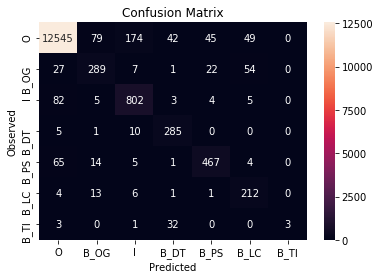

In [75]:
import seaborn as sn
from sklearn.metrics import confusion_matrix

ner_labels = ['O', 'B_OG', 'I', 'B_DT', 'B_PS', 'B_LC', 'B_TI']

cm = confusion_matrix(unpadded_label,unpadded_pred)
df_cm = pd.DataFrame(cm, index = ner_labels,
                  columns = ner_labels)
sn.heatmap(df_cm, annot=True, fmt=".0f").set(title="Confusion Matrix", xlabel="Predicted", ylabel="Observed",)

for words in the dev set...

In [76]:
#Actual O Predicted I
print(tokenizer.decode(unpadded_txt[(unpadded_label == 0)&(unpadded_pred == 2)]))

올  스타  일 위 차 팀 하   구   설  구 전 만 구  구 주 2 군 구 날 삼성 프로  LG  로 이 ( 차 마 스타 - 신 도시  국제 운동  국제 판 영화  전문 에 일 하 국제 영화 영화 국제 만 내 세 동   Summer TV  마 국제 키 인터넷 방송  환경 영화 공 일 심 심  이 서 가  점   net   2 TV 명 화 심 과 타  앞  만 6   날 나이  2 TV 일 달 전 통신  시 야 여름  구 파    후 박  모  시 미 동안  정도 모 모    전  일 -  - 종합 -   달  FC 축구 축구 만  올해 축구 팀 삼성 트 아시아 일  산업 진 만 축구   스    일


In [77]:
#Actual I Predicted O
print(tokenizer.decode(unpadded_txt[(unpadded_label == 2)&(unpadded_pred == 0)]))

사 산  잠 리  팔 사 군 군 머 데 레이 산  잠  지구 지구 지구 허 필 회 이 자 폭 3 자 에 시 내 후 14 신 학교 한  야외 자 자  com 의 담 베이 페 공 가족 부  FM 의 황 자 CR 방송 와 아이 들 ? 씨 대 그 스타 모 S -  가 대표 골 대 황 2 의  매 이 골 호 골


In [78]:
#Actual B_PS Predicted 0
print(tokenizer.decode(unpadded_txt[(unpadded_label == 4)&(unpadded_pred == 0)]))

분 7 신경 한  소리 회장  카  에  라 만 현 영 해 보 H H 비 비 비 세 자   구 라  신 7  보 풍경 자 MC   신 동 동 더 THE   데 와이 영 의 도 그린 Green 45 비   터 이 천 축구 제 천 천
